# Gene Regression

This notebook demonstrates how to evaluate the features stored in the anndata.obsm by using the downstream gene regression task. \
(Predicting the gene expression of a spot based on the cell_type proportions and the spatial covariates.)\
Further analysis of gene regression results with all spatial covariates can be found in the code to reproduce figures from the paper.

In [1]:
# TO REMOVE when notebook is stable

%load_ext autoreload
%autoreload 2

### Common Imports

In [2]:
import numpy
import torch
import tarfile
import os
import matplotlib
import matplotlib.pyplot as plt
from anndata import read_h5ad

import seaborn as sns

# tissue_purifier import
import tissue_purifier as tp
from tissue_purifier.genex.gene_utils import *

### Download the annotated anndata object 

This assumes you have run main_2_featurize.py. Altenatively you can use the anndata files generated by running notebook2_all.

In [3]:
annotated_anndata_dest_path = os.path.abspath("../../TissueMosaic_Figures/TissueMosaic_data/")
annotated_anndata_dest_folder = os.path.join(annotated_anndata_dest_path, "testis_anndata_corrected_doubletmode_annotated")

# Make a list of all the h5ad files in the annotated_anndata_dest_folder
fname_list = []
for f in os.listdir(annotated_anndata_dest_folder):
    if f.endswith('.h5ad'):
        fname_list.append(f)
print(fname_list)

['wt3_dm.h5ad', 'wt1_dm.h5ad', 'diabetes2_dm.h5ad', 'wt2_dm.h5ad', 'diabetes1_dm.h5ad', 'diabetes3_dm.h5ad']


### Decide how to filter the anndata object

In [4]:
# filter cells parameters
fc_bc_min_umi = 100                  # filter cells with too few UMI
fc_bc_max_umi = 3000                  # filter cells with too many UMI
fc_bc_min_n_genes_by_counts = 10     # filter cells with too few GENES
fc_bc_max_n_genes_by_counts = 2500   # filter cells with too many GENES
fc_bc_max_pct_counts_mt = 5          # filter cells with mitocrondial fraction too high

# filter genes parameters
fg_bc_min_pct_cells_by_counts = 10      # filter genes which appear in too few pct of CELLS

# filter rare cell types parameters
fctype_bc_min_cells_absolute = 100   # filter cell-types which are too RARE in absolute number
fctype_bc_min_cells_frequency = 0.05 # filter cell-types which are too RARE in relative abundance

### Open the first anndata 

In [5]:
adata = read_h5ad(filename=os.path.join(annotated_anndata_dest_folder, fname_list[0]))
adata

AnnData object with n_obs × n_vars = 29178 × 24450
    obs: 'x', 'y', 'UMI', 'cell_type'
    uns: 'status'
    obsm: 'cell_type_proportions'

In [6]:
## add in ncv_k10 as spatial covariate

from tissue_purifier.data import SparseImage
## convert adata to sp_img

sp_img = SparseImage.from_anndata(adata, x_key = 'x', y_key = 'y', category_key = 'cell_type_proportions')
ncv_k10 = sp_img.compute_ncv(feature_name = 'k10', k=10)
adata = sp_img.to_anndata()
adata

[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.


number of elements ---> 29178
mean and median spacing 15.90507495709278, 15.497339152935078
The dense shape of the image is -> torch.Size([9, 1215, 1212])


AnnData object with n_obs × n_vars = 29178 × 24450
    obs: 'x', 'y', 'UMI', 'cell_type'
    uns: 'status'
    obsm: 'cell_type_proportions', 'k10'

### compute few metrics

In [7]:
import scanpy as sc
cell_type_key = "cell_type"

# mitocondria metrics
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# counts cells frequency
tmp = adata.obs[cell_type_key].values.describe()
print(tmp)
mask1 = (tmp["counts"] > fctype_bc_min_cells_absolute)
mask2 = (tmp["freqs"] > fctype_bc_min_cells_frequency)
mask = mask1 * mask2
cell_type_keep = set(tmp[mask].index.values)
adata.obs["keep_ctype"] = adata.obs["cell_type"].apply(lambda x: x in cell_type_keep)

adata.var["pct_cells_by_counts"] = adata.var["n_cells_by_counts"]/adata.X.shape[0] * 100

# Note that adata has extra annotation now
adata

             counts     freqs
categories                   
ES             7946  0.272328
Endothelial       1  0.000034
Leydig           15  0.000514
Macrophage        2  0.000069
Myoid             1  0.000034
RS            13909  0.476695
SPC            7131  0.244396
SPG              34  0.001165
Sertoli         139  0.004764


AnnData object with n_obs × n_vars = 29178 × 24450
    obs: 'x', 'y', 'UMI', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'keep_ctype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'pct_cells_by_counts'
    uns: 'status'
    obsm: 'cell_type_proportions', 'k10'

### Filter out cells, genes and cell-type

In [8]:
adata = adata[adata.obs["total_counts"] > fc_bc_min_umi, :] 
adata = adata[adata.obs["total_counts"] < fc_bc_max_umi, :] 
adata = adata[adata.obs["n_genes_by_counts"] > fc_bc_min_n_genes_by_counts, :] 
adata = adata[adata.obs["n_genes_by_counts"] < fc_bc_max_n_genes_by_counts, :] 
adata = adata[adata.obs["pct_counts_mt"] < fc_bc_max_pct_counts_mt, :]
adata = adata[adata.obs["keep_ctype"] == True, :]
adata = adata[:, adata.var["pct_cells_by_counts"] > fg_bc_min_pct_cells_by_counts]

### Show the cell-type count after filtering

In [9]:
tmp = adata.obs[cell_type_key].values.describe()
print(tmp)
adata

            counts     freqs
categories                  
ES            7864  0.272913
RS           13843  0.480410
SPC           7108  0.246677


View of AnnData object with n_obs × n_vars = 28815 × 1592
    obs: 'x', 'y', 'UMI', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'keep_ctype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'pct_cells_by_counts'
    uns: 'status'
    obsm: 'cell_type_proportions', 'k10'

### Split the dataset into train/test/val

In [10]:
from tissue_purifier.genex import *

covariate_key = "k10"

gene_dataset = make_gene_dataset_from_anndata(
        anndata=adata,
        cell_type_key='cell_type',
        cell_type_prop_key = 'cell_type_proportions',
        covariate_key=covariate_key,
        preprocess_strategy='raw',
        apply_pca=False)

In [11]:
train_dataset, test_dataset, val_dataset = next(iter(train_test_val_split(gene_dataset, train_size = 0.8, test_size = 0.1, val_size = 0.1, random_state=0)))

In [12]:
print("---------")
train_dataset.describe()
print("---------")
test_dataset.describe()
print("---------")
val_dataset.describe()

---------
covariates           ---> torch.Size([23052, 9])
cell_type_ids        ---> torch.Size([23052])
cell_type_props      ---> torch.Size([23052, 9])
counts               ---> torch.Size([23052, 1592])
k_cell_types         ---> 9
cell_type_mapping    ---> {'ES': 0, 'RS': 1, 'SPC': 2}
gene_names           ---> list of length 1592
---------
covariates           ---> torch.Size([2882, 9])
cell_type_ids        ---> torch.Size([2882])
cell_type_props      ---> torch.Size([2882, 9])
counts               ---> torch.Size([2882, 1592])
k_cell_types         ---> 9
cell_type_mapping    ---> {'ES': 0, 'RS': 1, 'SPC': 2}
gene_names           ---> list of length 1592
---------
covariates           ---> torch.Size([2881, 9])
cell_type_ids        ---> torch.Size([2881])
cell_type_props      ---> torch.Size([2881, 9])
counts               ---> torch.Size([2881, 1592])
k_cell_types         ---> 9
cell_type_mapping    ---> {'ES': 0, 'RS': 1, 'SPC': 2}
gene_names           ---> list of length 1592


### Note that the split is stratified by cell_types

/tmp/ipykernel_3569908/2540541026.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[c].set_xticklabels(labels=x_labels_raw, rotation=90)
/tmp/ipykernel_3569908/2540541026.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[c].set_xticklabels(labels=x_labels_raw, rotation=90)
/tmp/ipykernel_3569908/2540541026.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[c].set_xticklabels(labels=x_labels_raw, rotation=90)


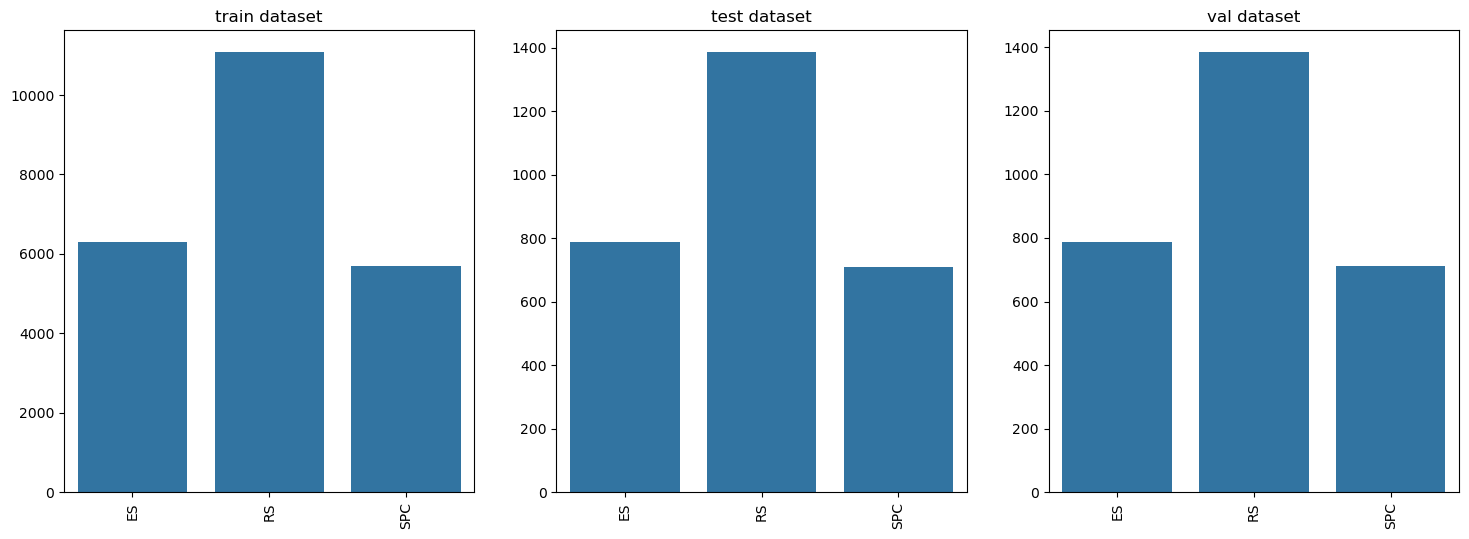

In [17]:
ncols=3
fig, axes = plt.subplots(ncols=ncols, figsize=(6*ncols,6))

for c, (dataset, title) in enumerate(zip([train_dataset, test_dataset, val_dataset], ["train dataset", "test dataset", "val dataset"])):
    x = list(dataset.cell_type_mapping.keys())
    y = torch.bincount(dataset.cell_type_ids).numpy()
    _ = sns.barplot(x=x, y=y, ax=axes[c])
    x_labels_raw = axes[c].get_xticklabels()
    axes[c].set_xticklabels(labels=x_labels_raw, rotation=90)
    _ = axes[c].set_title(title)

### Make a gene dataset from the anndata and split the dataset into a spatially partitioned train/test split

Here we choose the dino spot features

### Example training the model with no covariate (i.e. cell-type only)

In [18]:
umi_scaling = 10e3
cell_type_prop_scaling = 10e1
gr_baseline = GeneRegression(use_covariates=False,scale_covariates=True, umi_scaling=umi_scaling, cell_type_prop_scaling=cell_type_prop_scaling)

In [19]:
gr_baseline.train(
        train_dataset=train_dataset,
        use_covariates=False,
        regularization_sweep=False,
        alpha_regularization_strengths = np.array([1.0]))

fitting scaler and scaling covariates
start fitting genes
finished 100 genes
finished 200 genes
finished 300 genes
finished 400 genes
finished 500 genes
finished 600 genes
finished 700 genes
finished 800 genes
finished 900 genes
finished 1000 genes
finished 1100 genes
finished 1200 genes
finished 1300 genes
finished 1400 genes
finished 1500 genes


Text(0.5, 0, 'Coefficient Value')

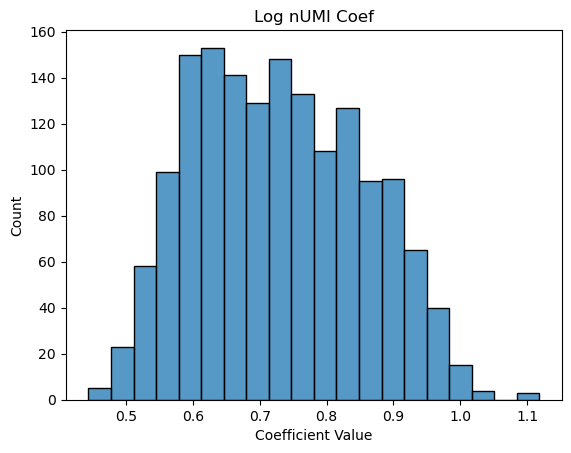

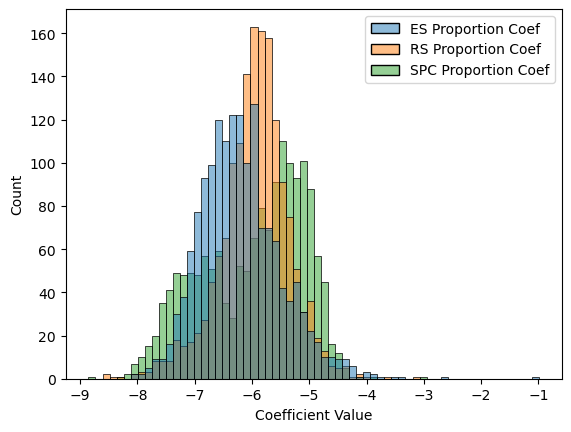

In [20]:
## visualize learned coefficients for all genes

log_numi_coef = []
es_prop_coef = []
rs_prop_coef = []
spc_prop_coef = []
for gene in adata.var_names:
    ## multiply learned coefficients by scaling factor to get effective coefficient
    log_numi_coef.append(umi_scaling*float(gr_baseline.clf_g[gene].coef_[0]))
    es_prop_coef.append(cell_type_prop_scaling*float(gr_baseline.clf_g[gene].coef_[1]))
    rs_prop_coef.append(cell_type_prop_scaling*float(gr_baseline.clf_g[gene].coef_[2]))
    spc_prop_coef.append(cell_type_prop_scaling*float(gr_baseline.clf_g[gene].coef_[4]))

plt.figure()
df_param = pd.DataFrame({'Log nUMI Coef': log_numi_coef, 'ES Proportion Coef': es_prop_coef, 'RS Proportion Coef': rs_prop_coef, 'SPC Proportion Coef': spc_prop_coef})
_ = sns.histplot(data=df_param, x='Log nUMI Coef')
plt.xlabel('Coefficient Value')
plt.title('Log nUMI Coef')

plt.figure()
cell_type_prop_coefs = ['ES Proportion Coef', 'RS Proportion Coef', 'SPC Proportion Coef']
_ = sns.histplot(data=df_param[cell_type_prop_coefs])
plt.xlabel('Coefficient Value')

### Example training the spatial covariate model

Here, we train a single model on all cell_types together, thus pooling coefficients b/w cell-types.

In [21]:
gr = GeneRegression(use_covariates=True,scale_covariates=True, umi_scaling=10e3, cell_type_prop_scaling=10e1)

In [22]:
gr.train(
        train_dataset=train_dataset,
        use_covariates=True,
        regularization_sweep=False,
        alpha_regularization_strengths = np.array([0.001]))

fitting scaler and scaling covariates
start fitting genes
finished 100 genes
finished 200 genes
finished 300 genes
finished 400 genes
finished 500 genes
finished 600 genes
finished 700 genes
finished 800 genes
finished 900 genes
finished 1000 genes
finished 1100 genes
finished 1200 genes
finished 1300 genes
finished 1400 genes
finished 1500 genes


Text(0.5, 0, 'Coefficient Value')

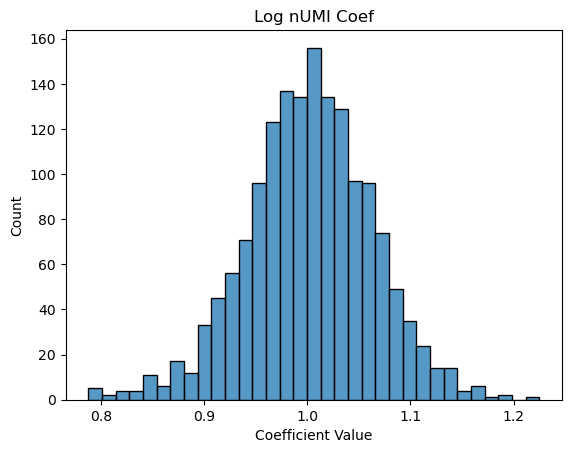

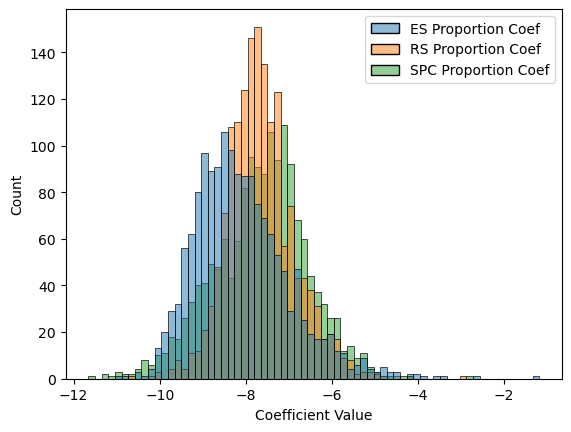

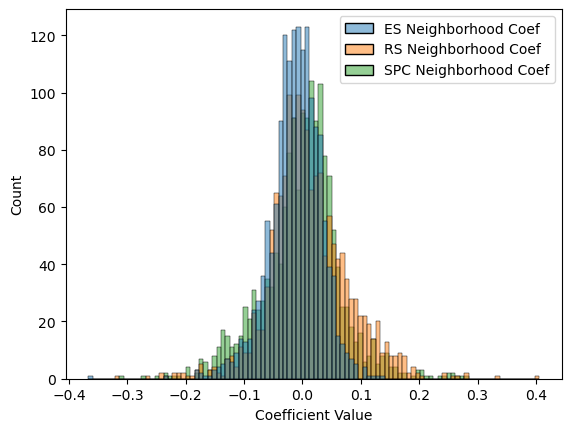

In [23]:
## visualize learned coefficients for all genes

log_numi_coef = []
es_prop_coef = []
rs_prop_coef = []
spc_prop_coef = []
es_neighborhood_coef = []
rs_neighborhood_coef = []
spc_neighborhood_coef = []
for gene in adata.var_names:
    ## multiply learned coefficients by scaling factor to get effective coefficient
    log_numi_coef.append(umi_scaling*float(gr.clf_g[gene].coef_[0]))
    es_prop_coef.append(cell_type_prop_scaling*float(gr.clf_g[gene].coef_[1]))
    rs_prop_coef.append(cell_type_prop_scaling*float(gr.clf_g[gene].coef_[2]))
    spc_prop_coef.append(cell_type_prop_scaling*float(gr.clf_g[gene].coef_[4]))
    es_neighborhood_coef.append(float(gr.clf_g[gene].coef_[10]))
    rs_neighborhood_coef.append(float(gr.clf_g[gene].coef_[11]))
    spc_neighborhood_coef.append(float(gr.clf_g[gene].coef_[13]))

plt.figure()
df_param = pd.DataFrame({'Log nUMI Coef': log_numi_coef, 'ES Proportion Coef': es_prop_coef, 'RS Proportion Coef': rs_prop_coef, 'SPC Proportion Coef': spc_prop_coef,
                        'ES Neighborhood Coef': es_neighborhood_coef, 'RS Neighborhood Coef': rs_neighborhood_coef, 'SPC Neighborhood Coef': spc_neighborhood_coef})
_ = sns.histplot(data=df_param, x='Log nUMI Coef')
plt.xlabel('Coefficient Value')
plt.title('Log nUMI Coef')

plt.figure()
cell_type_prop_coefs = ['ES Proportion Coef', 'RS Proportion Coef', 'SPC Proportion Coef']
_ = sns.histplot(data=df_param[cell_type_prop_coefs])
plt.xlabel('Coefficient Value')

plt.figure()
neighborhood_coefs = ['ES Neighborhood Coef', 'RS Neighborhood Coef', 'SPC Neighborhood Coef']
_ = sns.histplot(data=df_param[neighborhood_coefs])
plt.xlabel('Coefficient Value')

We see that the log nUMI coefficient is centered around 0, the coefficients for all 3 major cell types are similar, and the neighborhood coefficients are centered at 0, as expected

## Compare prediction performance of both models

Next, we compare how the trained models perform on predicting the gene expression of held out data. Note, the train/test splits are not spatially partitioned here just for demonstration purposes, so the test metrics will be inflated due to spatial leakage

In [24]:
## predict counts on test dataset
pred_counts_ng, counts_ng = gr.predict(test_dataset, return_true_counts=True)
pred_counts_ng_baseline, counts_ng_baseline = gr_baseline.predict(test_dataset, return_true_counts=True)

cell_type_ids = test_dataset.cell_type_ids
gene_names = test_dataset.gene_names

## compute evalution metrics using predicted counts
df_d_sq_gk_spatial, df_rel_q_gk_spatial = GeneRegression.compute_eval_metrics(pred_counts_ng=pred_counts_ng, 
                                                        counts_ng=counts_ng,
                                                        cell_type_ids = cell_type_ids,
                                                        gene_names = gene_names,
                                                        pred_counts_ng_baseline = pred_counts_ng_baseline)

df_d_sq_gk_baseline, df_rel_q_gk_baseline = GeneRegression.compute_eval_metrics(pred_counts_ng=pred_counts_ng_baseline, 
                                                        counts_ng=counts_ng,
                                                        cell_type_ids = cell_type_ids,
                                                        gene_names = gene_names,
                                                        pred_counts_ng_baseline = pred_counts_ng_baseline) 



predicting
scaling covariates
predicting
scaling covariates


Here to compare the performance of the baseline and spatial (neighborhood composition) models, we plot the deviance squared evaluation metric, which is a goodness-of-fit statistic, across all genes 

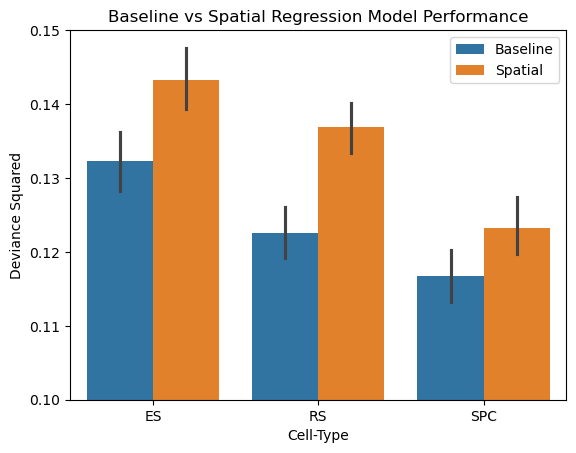

In [25]:
df1 = df_d_sq_gk_baseline
df2 = df_d_sq_gk_spatial

## rename columns to cell types
df1.columns = ['ES', 'RS', 'SPC']
df2.columns = ['ES', 'RS', 'SPC']

# Melt the dataframes to long format for seaborn
df1_melted = df1.melt(var_name='Cell-Type', value_name='Deviance Squared', ignore_index=False).reset_index().rename(columns={'index': 'Gene'})
df1_melted['Model'] = 'Baseline'

df2_melted = df2.melt(var_name='Cell-Type', value_name='Deviance Squared', ignore_index=False).reset_index().rename(columns={'index': 'Gene'})
df2_melted['Model'] = 'Spatial'

# Concatenate the melted dataframes
df_combined = pd.concat([df1_melted, df2_melted])

# Create the grouped bar plot
plt.figure()
sns.barplot(data=df_combined, x='Cell-Type', y='Deviance Squared', hue='Model')
plt.ylim(0.10, 0.15)
plt.title('Baseline vs Spatial Regression Model Performance')
plt.legend()
plt.show()

We see that across all 3 major cell types, the spatial regression model (using neighborhood composition as the spatial covariate) has a better fit to the data than the baseline cell-type only model across all analyzed genes